# Preliminary operations

## Drive Mount

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/Assignment/OriginalDataset

/content/gdrive/MyDrive/Assignment/OriginalDataset


## Libraries and seed

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
plt.rc('font', size=16) 
from sklearn.utils import  compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.9.2


## Functions definition

In [7]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true'),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None)  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [11]:
def build_cfmat(pred,matrix_gen,color="Reds",show=True):
    labels = matrix_gen.labels
    pred_val = np.argmax(pred, axis = 1)
    class_elems = [0,0,0]
    tot = len(labels)
    for i in range(len(class_elems)):
        class_elems[i] = np.count_nonzero(labels==i)
    class_elems = {
    0: class_elems[0],
    1: class_elems[1],
    2: class_elems[2],
    }
    
    cf_mat = tf.math.confusion_matrix(
    labels =labels ,
    predictions = pred_val
    )
    
    cf_mat = cf_mat.numpy().astype(float)
    for i in range(len(cf_mat)):
        cf_mat[i] = (cf_mat[i]/class_elems.get(i)*100).round(2)
    if show == True:
        df_cm = pd.DataFrame(cf_mat, columns=range(1,4), index = range(1,4))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,7))
        seaborn.set(font_scale=1.5)#for label size
        seaborn.heatmap(df_cm, cmap=color, annot=True, annot_kws={"size": 12}, fmt='g')
    return cf_mat

In [12]:
# Defining the function to get the image generator 
# In this case, since we will perform Transfer Learning and use the pre-trained 
# net preprocessing, No rescale is included or other preprocessing techniques are included 
# in the Image Generator. Only the train generator envisages some augmentation techniques. 
directory = "C:/Users/Andrea Braccio/Desktop/splitted_dataset-20221220T085630Z-001/splitted_dataset"
def define_generators(directory, bs, aug_gen):

  generators = {}
  training_dir = os.path.join(directory, 'train') 
  validation_dir = os.path.join(directory, 'val') 
  test_dir = os.path.join(directory, 'test') 

  generators['train'] = aug_gen.flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  generators['val'] = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  generators['test'] = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  return generators

# Preparing data

## Defining augmentation

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)
```



In [8]:
aug_generator = ImageDataGenerator( shear_range=0.1,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.6,1.4],
                                    fill_mode='constant',
                                    cval=0.1,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    #rescale=1/255.,
                                    preprocessing_function=None, #Included in the NN
                                   )

In [9]:
dataset_dir = "/content/gdrive/MyDrive/Assignment/OriginalDataset/splitted_dataset"
bs = 128

In [13]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 11124 images belonging to 3 classes.
Found 1253 images belonging to 3 classes.
Found 3093 images belonging to 3 classes.


In [ ]:
train_gen.class_indices

{'normal': 0, 'pneumonia': 1, 'tubercolosis': 2}

In [14]:
labels = list(train_gen.class_indices.keys())
print("Labels: ", labels)

Labels:  ['normal', 'pneumonia', 'tubercolosis']


In [ ]:
class_weights = dict(zip(np.unique(train_target), compute_class_weight(class_weight = "balanced", classes = np.unique(train_target), y = train_target)))
class_weights

{0: 0.8565264293419633, 1: 0.7455399061032864, 2: 2.0358974358974358}

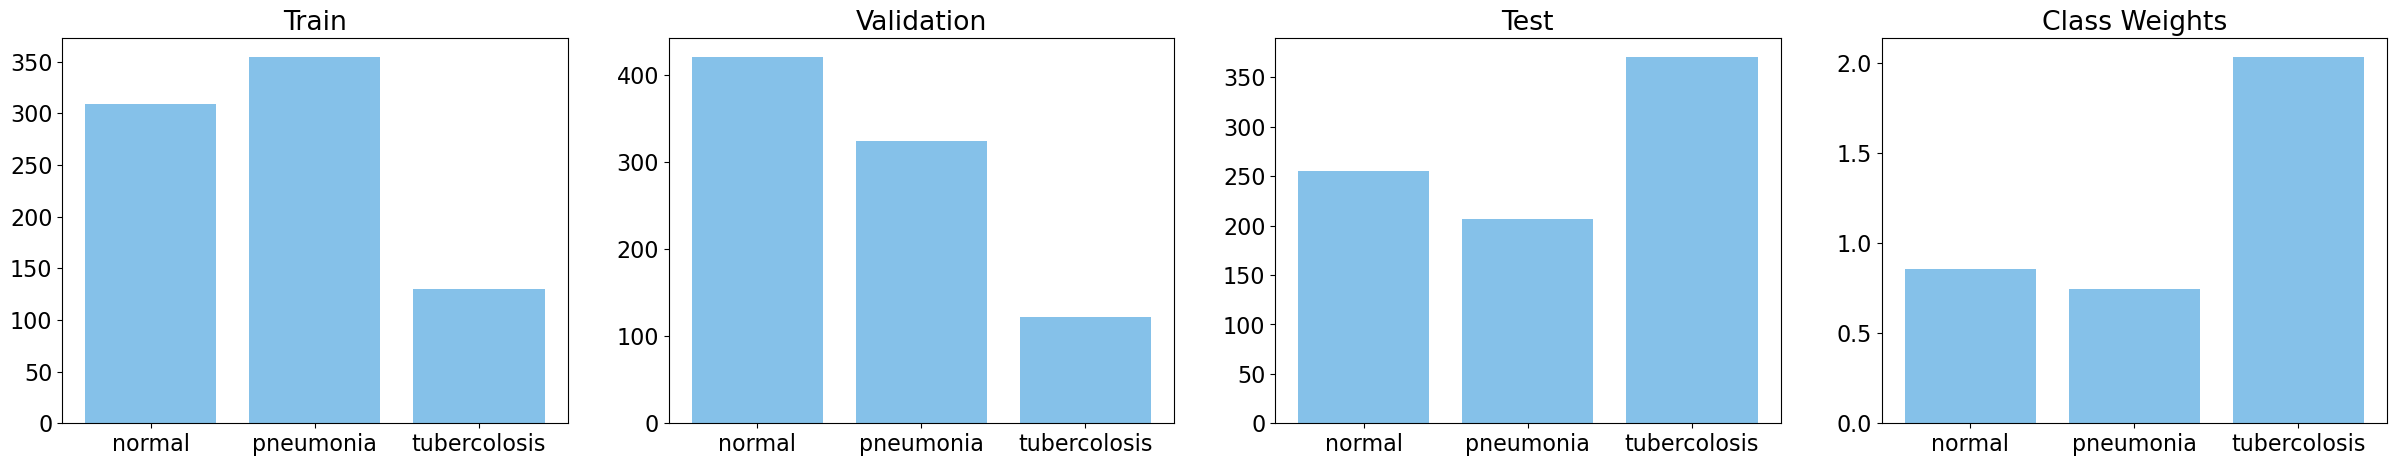

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(30, 5))
axs[0].bar(x=labels,height=train_target_cat.sum(axis=0), facecolor ='#85c1e9')
axs[0].set_title("Train", color = "black")
axs[0].tick_params(axis="both", colors = "black")

axs[1].bar(x=labels,height=val_target_cat.sum(axis=0), facecolor ='#85c1e9')
axs[1].set_title("Validation", color = "black")
axs[1].tick_params(axis="both", colors = "black")

axs[2].bar(x=labels,height=test_target_cat.sum(axis=0), facecolor ='#85c1e9')
axs[2].set_title("Test", color = "black")
axs[2].tick_params(axis="both", colors = "black")

axs[3].bar(x=labels,height=list(class_weights.values()), facecolor ='#85c1e9')
axs[3].set_title("Class Weights", color = "black")
axs[3].tick_params(axis="both", colors = "black")

## Parameters

In [ ]:
input_shape = (200, 200, 3)
supernet_input_shape= input_shape
n_output = len(labels)
epochs = 50
mtrcs = ['accuracy']
monmtr = 'val_accuracy'

In [ ]:
def build_tl_model(dp_rate1=0.3, dp_rate2=0.3, nc=512, elastic_lambda= 1e-3,  lr = 1e-3):

  supernet = tfk.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=supernet_input_shape,
    pooling='avg')

  # Use the supernet as feature extractor
  supernet.trainable = False

  inputs = tfk.Input(shape=input_shape)
  x = tfk.applications.densenet.preprocess_input(inputs)

  x = supernet(x)
  x = tfkl.Dropout(dp_rate1, seed=seed)(x)   
  x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
  x=tfkl.LeakyReLU()(x)
  x = tfkl.Dropout(dp_rate2, seed=seed)(x)  
  outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
  tl_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07),
  loss="categorical_crossentropy",
  metrics=["accuracy"],
  )

  return tl_model

In [ ]:
lr = 1e-3
model = build_tl_model(
    dp_rate1=0.4, 
    dp_rate2=0.4, 
    nc=64, 
    elastic_lambda= 1e-3,  
    lr = lr)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

Unfreeze the supernet layers, each layer that is set to trainable will be included in the gradient descent optimization starting from the weights that have been imported at supernet definition. 

In [ ]:
supernet_name = 'densenet121'
# d = 313 # to unfreeze the whole con5 block
d = -115 # to keep all layers freezed 

model.get_layer(supernet_name).trainable = True
for i, layer in enumerate(model.get_layer(supernet_name).layers[:d]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer(supernet_name).layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 tf.math.truediv True
2 tf.nn.bias_add True
3 tf.math.truediv_1 True
4 densenet121 True
5 dropout True
6 dense True
7 leaky_re_lu True
8 dropout_1 True
9 dense_1 True


In [ ]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=lr), metrics=mtrcs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 200, 200, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 200, 200, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-8),
    ] 
).history

Epoch 1/50
50/50 [==============================] - 21s 272ms/step - loss: 3.6273 - accuracy: 0.5668 - val_loss: 3.6169 - val_accuracy: 0.7682 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 14s 281ms/step - loss: 2.3731 - accuracy: 0.6524 - val_loss: 2.0006 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 14s 279ms/step - loss: 2.0832 - accuracy: 0.7053 - val_loss: 2.2034 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 13s 268ms/step - loss: 1.9585 - accuracy: 0.7015 - val_loss: 2.4326 - val_accuracy: 0.6517 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 14s 287ms/step - loss: 1.7112 - accuracy: 0.7431 - val_loss: 2.1641 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 14s 277ms/step - loss: 1.5670 - accuracy: 0.7997 - val_loss: 1.5473 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 7/50
50/50 [==============================] - 14s 285ms/st

In [ ]:
#Fine-tuning unfreezing Conv4
model.get_layer(supernet_name).trainable = True
for i, layer in enumerate(model.get_layer(supernet_name).layers[:141]):
  layer.trainable=False

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics=mtrcs)
history = model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-8),
    ] 
).history

Epoch 1/50
50/50 [==============================] - 28s 445ms/step - loss: 0.9877 - accuracy: 0.8060 - val_loss: 0.9436 - val_accuracy: 0.8512 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - 20s 405ms/step - loss: 0.9633 - accuracy: 0.8224 - val_loss: 0.9760 - val_accuracy: 0.8431 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - 24s 493ms/step - loss: 0.8824 - accuracy: 0.8678 - val_loss: 0.9273 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 4/50
50/50 [==============================] - 15s 298ms/step - loss: 0.8118 - accuracy: 0.8678 - val_loss: 0.9664 - val_accuracy: 0.8397 - lr: 1.0000e-04
Epoch 5/50
50/50 [==============================] - 16s 328ms/step - loss: 0.7799 - accuracy: 0.9030 - val_loss: 0.9781 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 6/50
50/50 [==============================] - 15s 280ms/step - loss: 0.7738 - accuracy: 0.8766 - val_loss: 0.9136 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 7/50
50/50 [======================

In [ ]:
#Fine-tuning unfreezing Conv3
model.get_layer(supernet_name).trainable = True
for i, layer in enumerate(model.get_layer(supernet_name).layers[:53]):
  layer.trainable=False

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics=mtrcs)
history = model.fit(
    x = train_gen,
    epochs = 15,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-8),
    ] 
).history

Epoch 1/15
50/50 [==============================] - 21s 298ms/step - loss: 0.6362 - accuracy: 0.9219 - val_loss: 0.8018 - val_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 2/15
50/50 [==============================] - 14s 273ms/step - loss: 0.6232 - accuracy: 0.9282 - val_loss: 0.8098 - val_accuracy: 0.8720 - lr: 1.0000e-05
Epoch 3/15
50/50 [==============================] - 15s 290ms/step - loss: 0.5728 - accuracy: 0.9383 - val_loss: 0.7990 - val_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 4/15
50/50 [==============================] - 14s 281ms/step - loss: 0.5960 - accuracy: 0.9320 - val_loss: 0.8001 - val_accuracy: 0.8720 - lr: 1.0000e-05
Epoch 5/15
50/50 [==============================] - 14s 289ms/step - loss: 0.5688 - accuracy: 0.9446 - val_loss: 0.8108 - val_accuracy: 0.8581 - lr: 1.0000e-05
Epoch 6/15
50/50 [==============================] - 14s 286ms/step - loss: 0.5500 - accuracy: 0.9395 - val_loss: 0.8125 - val_accuracy: 0.8685 - lr: 1.0000e-05
Epoch 7/15
50/50 [======================

53/53 [==============================] - 7s 131ms/step


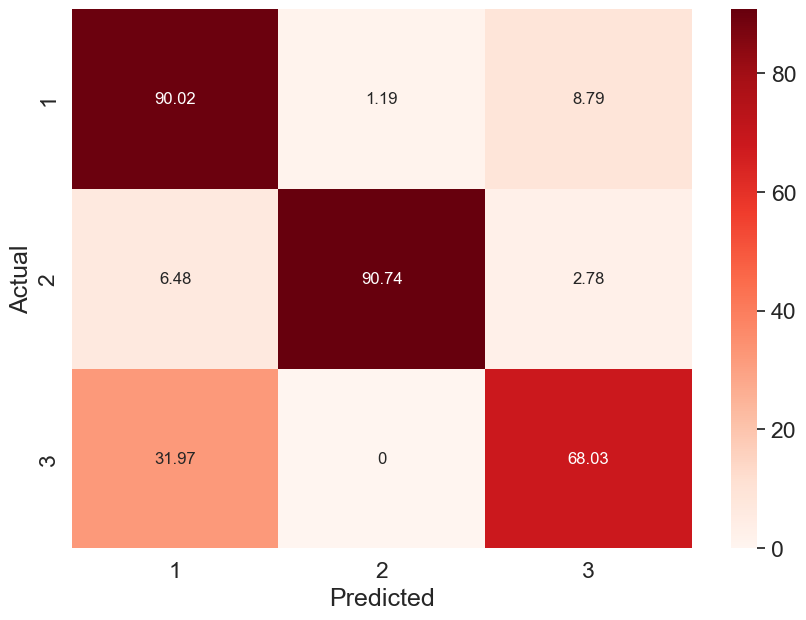

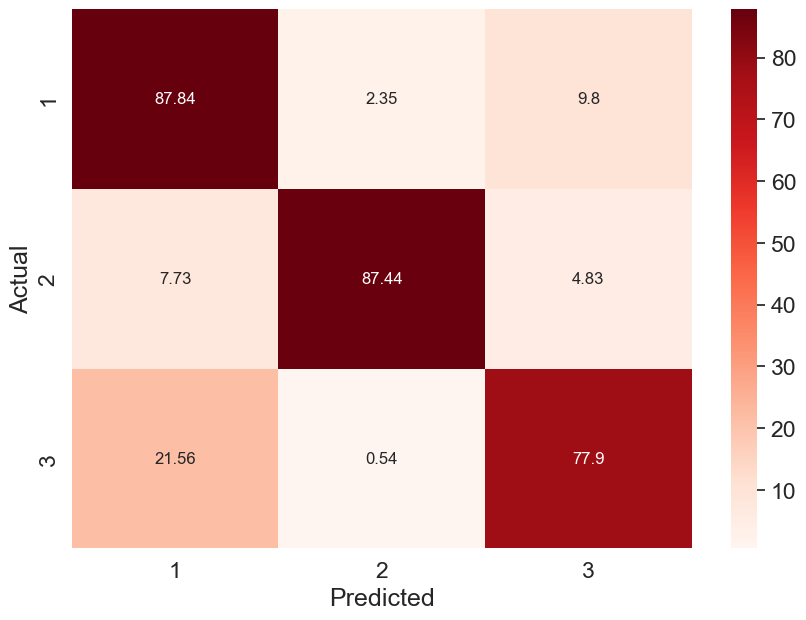

In [ ]:
#Build confusion matrices
mat = build_cfmat(pred = model.predict(valid_gen),matrix_gen = gens['val'])
mat2 = build_cfmat(pred = model.predict(test_gen),matrix_gen = gens['test'])

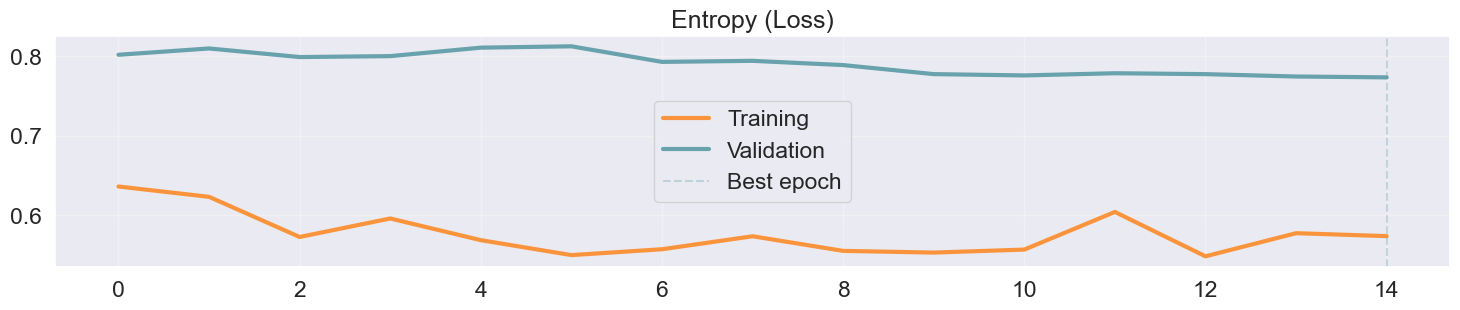

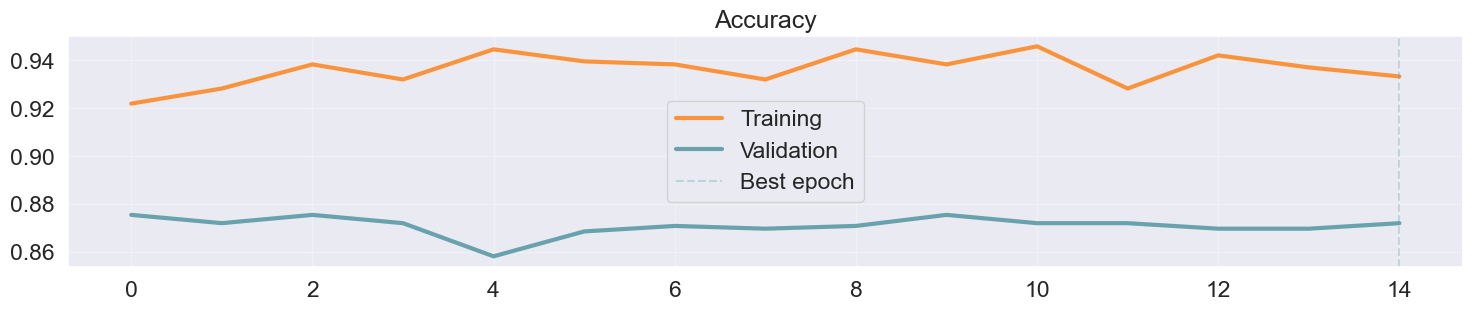

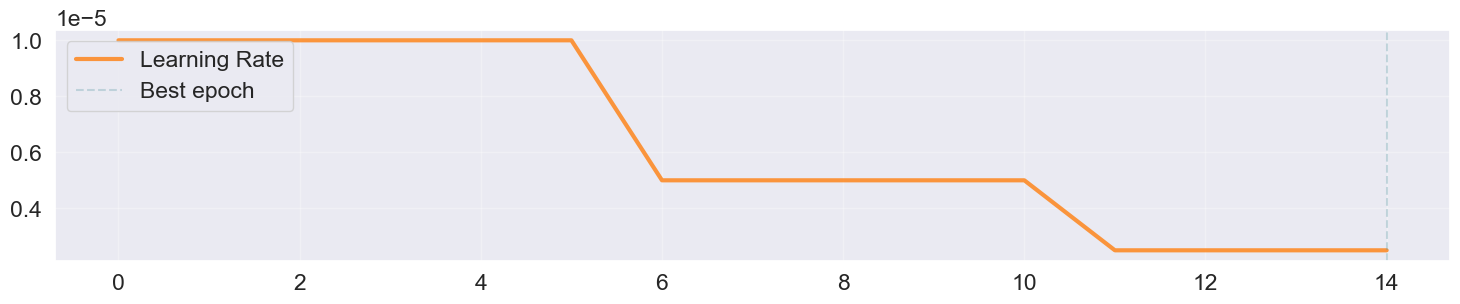

In [ ]:
best_epoch = np.argmin(history['val_loss'])

plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save("models/DenseNet_0") #save the model

INFO:tensorflow:Assets written to: models/DenseNet_0\assets


INFO:tensorflow:Assets written to: models/DenseNet_0\assets


In [17]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true'),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average=None)  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

25/25 [==============================] - 33s 1s/step
Model: /content/gdrive/MyDrive/AI project/models/3. DenseNet_20_12
Accuracy: 0.8768186226964112
F1 score: [0.90782048 0.91407223 0.67287544]


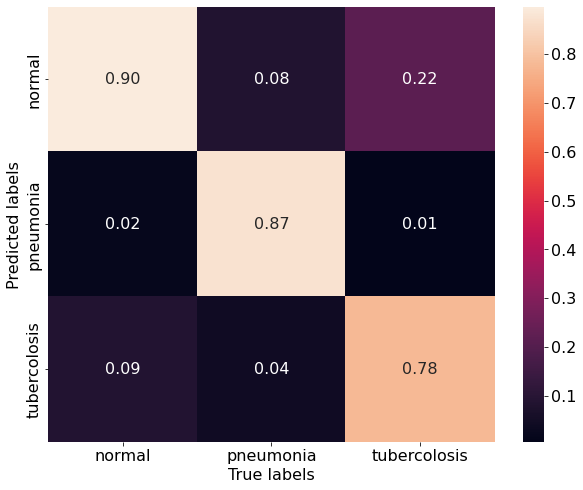

In [18]:
metrics = evaluate_model_f('/content/gdrive/MyDrive/AI project/models/3. DenseNet_20_12', test_gen, test_target_cat, labels)

In [20]:
print("Precision: "+ str(metrics["precision"]))
print("Recall: "+ str(metrics["recall"]))

Precision: [0.91893362 0.95697523 0.59221311]
Recall: [0.89697292 0.87485101 0.77897574]


In [23]:
np.save('/content/gdrive/MyDrive/AI project/models/prediction densenet.npy', metrics["predictions"])

In [31]:
from sklearn.metrics import roc_auc_score
legend = {'Normal': 0, 'Pneumonia': 1, 'Tubercolosis': 2}
pred = metrics["predictions"]
target= test_target
auc = np.zeros(3)
for c, i in legend.items():
  probs = pred[:,i]
  y = (target==i).astype(int)
  auc[i] = roc_auc_score(y, probs)

auc

array([0.9587839 , 0.99235791, 0.94464392])